In [2]:
#
#    IMPORTANT: RUN JUPYTER NOTEBOOK IN "am4ip" ROOT FOLDER (NOT THE ONE IN SRC FOLDER)
#
import os
import sys
import torch
import requests
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from IPython.display import HTML, display

sys.path.append("../../src")

from am4ip.utils import expanded_join

In [3]:
%%bash
export CUDA_VISIBLE_DEVICES=0

# Advanced Methods for Image Processing (and Computer Vision)
---------

## Course 3

# Generative Models
---

## I. Introduction

## II. Families of generative models for images

## III. Evaluation criterias

# Introduction
---

## I.1. Generative VS discriminative models

## I.2. Real-world Applications

## I.3. A probabilistic perspective

# Discriminative models
---

- Input data $x\in \mathcal{X}$ and target data $y \in \mathcal{Y}$ that are real-world observations
- Some examples:
    - Image Classification → pairs of image and label
    - Temperature Regression → pairs of $N$ past recorded temperatures and the temperature to predict at $t+1$
    - Object Segmentation → pairs of image and binary masks

- **Discriminative models**:
    - Input data: $x \in \mathcal{X}$
    - Target data: $y \in \mathcal{Y}$
    - **Goal**: learn $f_\theta$ such that $y \approx \hat{y} = f_\theta(x)$

# Generative models
---

- Target data $x \in \mathcal{X}$ a real-world observation
- Some examples:
    - Human face generation: $x$ is an image of human face, and $\mathcal{X}$ is all possible human faces
    - Molecule synthesis: $x$ is a graph representing a molecule, and $\mathcal{X}$ is all possible molecules (even unstable ones)
    - Text synthesis: $x$ is a text (word, sentence, paragraph, ...), and $\mathcal{X}$ is all possible text in the world (gibberish included)
- **Generative models**
    - Input data: Latent variable $z \in \mathcal{Z}$ sampled from a **known** distribution $D_\mathcal{Z}$
    - Target data: $x \in \mathcal{X}$ sampled from an **unknown and possibly complex** distribution $D_\mathcal{X}$
    - **Goal**: learn $g_\theta$ such that $\hat{x} = g_\theta(z)$ sampled from a distribution $D_{g(\mathcal{Z})} \approx D_\mathcal{X}$

Underlying goal: $\forall x \in \mathcal{X}, \exists \ z \in \mathcal{Z}$ such that $g_\theta(z) \approx x$

# Example: Sampling from a Gaussian distribution
---

<center>You have access to a Hardware (True) Random Number Generator → Uniform distribution in $[0, 1]$</center>


<p><center><b>Question: How to sample from a Gaussian distribution from a Uniform distribution?</b></center></p>

- **Generative model perspective**:
    - Input latent space: $z \in \mathbb{R}$ with $z \sim U(0, 1)$
    - Target space: $x \in \mathbb{R}$ with $x \sim \mathcal{N}(0, 1)$
    - Find $g_\theta$ to map the uniform distribution to the Normal distribution

# Example: Sampling from a Gaussian distribution
---

- **Box-Muller Transform**: There exists a close form for $g_\theta$ in that case
    - Sample $z_1, z_2 \sim U(0, 1)$
    - Compute $x_1$ and $x_2$ as follows:
        - $x_1 = \sqrt{-2\log(z_1)} \ \cos(2 \pi \ z_2)$
        - $x_2 = \sqrt{-2\log(z_1)} \ \sin(2 \pi \ z_2)$

# Example: Sampling from a Gaussian distribution
---

In [4]:
def plot_fig(x, z, true_pdf=True, nbins=100):
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(30, 7))
    
    axs[0].hist(z, bins=nbins, density=True, label=r"$\widehat{p}_\mathcal{Z}$")
    axs[1].hist(x, bins=nbins, density=True, label=r"$\widehat{p}_\mathcal{X}$")
    
    axs[0].set_xlabel(r"Latent space $\mathcal{Z}$", fontsize=40)
    axs[1].set_xlabel(r"Target space $\mathcal{X}$", fontsize=40)
    
    axs[0].set_xlim(-1, 2)
    axs[1].set_xlim(-4, 4)
    
    if true_pdf:
        inp_z = np.arange(-1, 2, step=0.01)
        pdf_z = np.logical_and(inp_z >= 0, inp_z <= 1)
        pdf_z = pdf_z.astype(float)
        
        x_min, x_max = np.min(x), np.max(x)
        inp_x = np.arange(x_min, x_max, step=0.01)
        pdf_x = np.exp(-0.5 * inp_x**2) / np.sqrt(2 * np.pi)
        
        axs[0].plot(inp_z, pdf_z, lw=10, label=r"$p_\mathcal{Z}$")
        axs[1].plot(inp_x, pdf_x, lw=10, label=r"$p_\mathcal{X}$")
        
    axs[0].legend(fontsize=30)
    axs[1].legend(fontsize=30)
    plt.show()

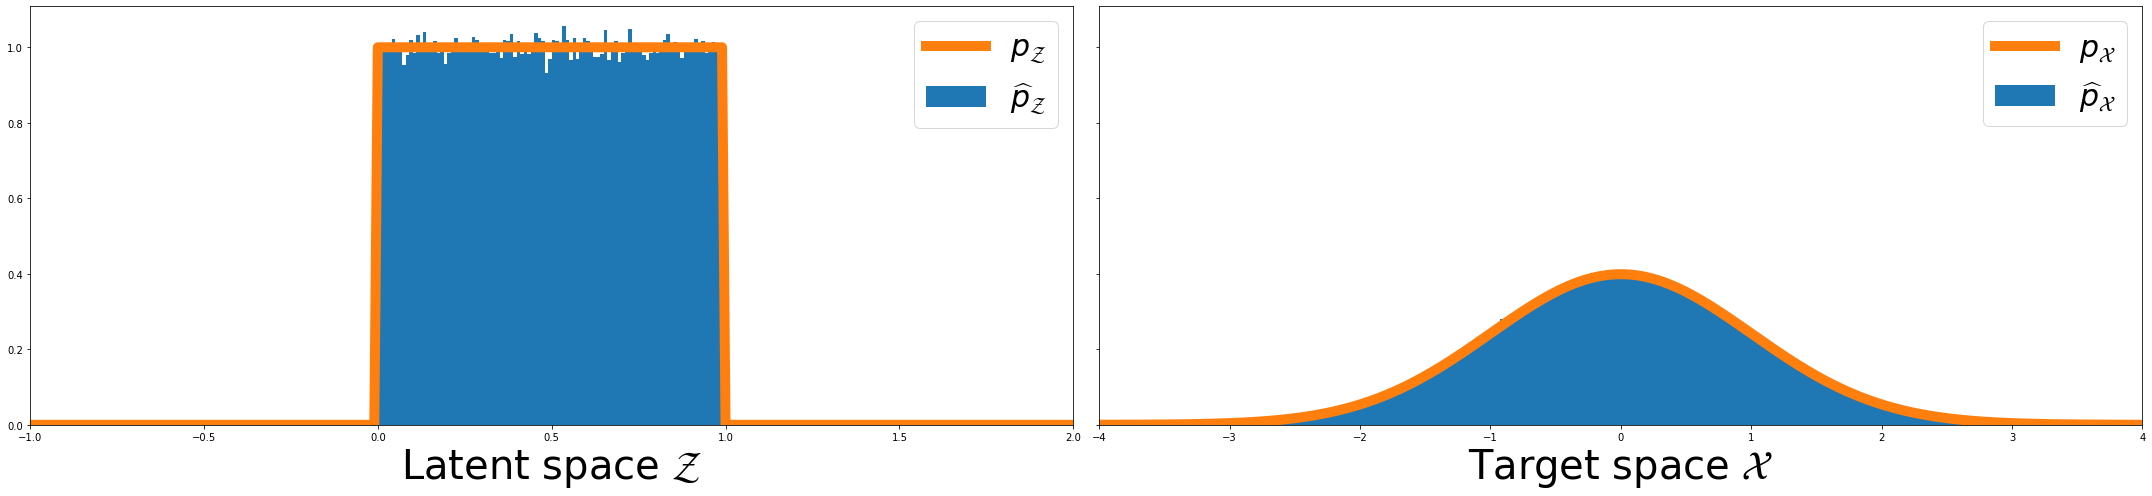

In [6]:
N = 100000
z = np.random.uniform(low=0., high=1., size=(2*N,)).astype(dtype=np.float64)
x = np.concatenate([np.sqrt(-2. * np.log(z[:N])) * np.cos(2. * np.pi * z[N:]),
                    np.sqrt(-2. * np.log(z[:N])) * np.sin(2. * np.pi * z[N:])])

plot_fig(x, z, true_pdf=True)


# Real-world Applications
---

- **Drawing assistant**: use generative models to remove objects or persons in images, extend an image, change current style to the one of a famous painter, ...
- **Synthetic data for training**: generate synthetic images for fine-tuning, simulation-based training for robots, ...
- **text-to-speech**: generate a person voice from a text and a record of the target's voice. Could also generate the video (lip-sync)
- **Text generation**: ChatGPT and its variants...

A probabilistic perspective
---

- **Task**: Learn a representation of an **intractable and complex** distribution $D_\mathcal{X}$ defined over $\mathbb{R}^n$ with $n >> 1$
- Training data: set of **independent and identically distributed** (i.i.d) samples from $\mathcal{X}$
- **Goal**: Find a generator $g_\theta: \mathbb{R}^p \to \mathbb{R}^n$ that maps samples from $\mathcal{Z}$ defined over $\mathbb{R}^p$ to points in $\mathbb{R}^n$ such that $D_\mathcal{X} \approx D_{g(\mathcal{Z})}$.
- learned pdf of $D_{g(\mathcal{Z})}$ will be denoted $q_\theta$: $D_\mathcal{X} \approx D_{g(\mathcal{Z})} \iff p_\mathcal{X} \approx q_\theta$
- Only contraints on $\mathcal{Z}$
    - Simple enough so we can sample $z \sim D_\mathcal{Z}$ easily
    - Ability to compute the probability of $z$ named $p_\mathcal{Z}(z)$ for any $z$
- **Deep Generative Modelling** → $g_\theta$ is parametrized by a Deep Neural Network (Transformers, ConvNets, ...)

# A probabilistic perspective (2)
---
- Sometimes, you might be interested by the likelihood of a sample $x$, which requires you to compute the (usually untractable) marginal distribution:
$$\begin{align}p_\mathcal{X}(x) = \int p_g(x | z) \ p_\mathcal{Z}(z) \ dz\end{align}$$
- where $p_g$ is usually:
    - A Normal distribution centered on $g(z)$ (continuous case)
    - A Bernouilli distribution (binary case)

# High-level overview of training
---

- DNN architecture is important → We will focus only on the most usual architectures
- **Unsupervised training**: We don't have pairs $(z, x) \in \mathcal{Z} \times \mathcal{X}$
- Only objective: match distributions $D_\mathcal{X}$ and $D_{g(\mathcal{Z})}$ → known as the **two-sample hypothesis test problem**
    - Hard to solve in practice for high-dimensional distributions
    - Only have access to samples and not to the true distribution
    - Rely on distance between distribution → **divergence between ditribution**
- Most common one: Kullback-Leibler (KL) divergence

$$\begin{align}D_\text{KL}(p \ || \ q) = \mathbb{E}_{p}\left[\log\left(\frac{p}{q}\right)\right] = \int p(x) \log\left(\frac{p(x)}{q(x)}\right) dx = - H(p) + CE(p, q)\end{align}$$
where:
- $H(p) = -\int p \log(p)$ : Entropy of p
- $CE(p, q) = -\int p \log(q)$ : Cross-Entropy between p and q

# Divergence between distributions
---
- Similar to distance between vector, but with less restrictions

<fieldset class="definition">
<legend class="definition">Definition: Divergence between distributions</legend>
Given two pdf $p_\mathcal{X}: \mathcal{X} \to \mathbb{R}$ and $q_\theta: \mathcal{X} \to \mathbb{R}$, the <b>divergence between distributions</b> $p_\mathcal{X}$ and $q_\theta$, denoted $D(p_\mathcal{X} \ || \ q_\theta)$ has the following properties:
    
<ul>
    <li>$\forall p_\mathcal{X},q_\theta, D(p_\mathcal{X} \ || \ q_\theta) \geq 0 $</li>
    <li>$D(p_\mathcal{X} \ || \ q_\theta) = 0 \iff p_\mathcal{X} = q_\theta$</li>
</ul>

Notably, there is no constraints about symmetry, or triangle inequality contrary to distances between vetors.
</fieldset>

- Training: minimize $D(p_\mathcal{X} \ || \ q_\theta)$

# Families of generative models
---

## II.1. Normalizing flow
## II.2. Variational autoencoders
## II.3. Generative adversarial networks
## II.4. Diffusion models 

# Families of generative models
---

1. **(Continuous) Normalizing Flow**
    - Assume $p = n$ which is for some real-world applications unfeasible
    - Build $g_\theta$ as a combination of invertible functions
    - If $g_\theta$ continuous and differentiable → direct formula to get $p_\mathcal{X}(x)$
2. **Variational Autoencoders (VAE)**
    - Non invertible $g_\theta$ → p << n
    - Have a second network approximating the posterior density $p_g(z | x)$
    - Two opposite training objectives: minimize reconstruction and maximize approximate posteriors of latent distribution
3. **Generative Adversarial Network (GAN)**
    - No latent variable → Tackle directly the two-sample hypothesis problem
    - Use a discriminator to parametrize the distance between distribution
4. **Diffusion models**
    - Also assume $p = n$, but forward 
    - Extension of auto-regressive models
    - forward process is a diffusion process, training aims at reversing it
    - Learn to predict the noise at a given timestamp
    - Reconstruct an image from noise iteratively

# Normalizing Flow
---
- Assume $p = n$ which is for some real-world applications untractable
- If $g_\theta$ continuous and differentiable → direct formula to get $p_\mathcal{X}(x)$
- If $g_\theta$ is simple enough → fast forward and easy to sample $z$
- Build $g_\theta$ as a combination of invertible functions
$$\begin{align} g_\theta = g_K \circ g_{K-1} \circ \dots \circ g_1 \end{align}$$

# Maximum Likelihood Training
---

- All $g_i$ invertible → Change of variables formula to approximate likelihood:
$$\begin{align} p_\mathcal{X} \approx q_\theta(x) &= p_\mathcal{Z}\left(g_\theta^{-1}(x)\right) \left|\det\left(J_{g_\theta^{-1}}(x)\right)\right| \\
&= p_\mathcal{Z}\left(g_\theta^{-1}(x)\right) \prod_{i=1}^K \left|\det\left(J_{g_i^{-1}}(x)\right)\right|
\end{align}$$
- $J_f(x)$ is the Jacobian matrix of size $n \times n$:
$$\begin{align}
J_f(x) = \begin{bmatrix}\frac{\partial f_i}{\partial x_j}\end{bmatrix}_{i,j}
\end{align}$$
- Training objective → maximize likelihood = maximize log-likelihood = minimize its opposite
$$\begin{align}
\mathcal{L}_\theta &= - \ \mathbb{E}_{x \sim D_\mathcal{X}}\left[\log\left(q_\theta(x)\right)\right] \\
&= \mathbb{E}_{x \sim D_\mathcal{X}}\left[ - \ \log\left(p_\mathcal{Z}\left(g_\theta^{-1}(x)\right)\right) - \sum_{i=1}^K \log\left|\det\left(J_{g_i^{-1}}(x)\right)\right| \right]
\end{align}$$
- Model $p_\mathcal{Z}\left(g_\theta^{-1}(x)\right)$ as $K$ independant normal distribution $\mathcal{N}(0 ; \mathbf{I}_n)$

# Maximum Likelihood Training (2)
---

- Training procedure:
    - Sample a batch of $N$ samples $x_k \sim D_\mathcal{X}$
    - Compute all $g_i^{-1}(x_k)$
    - Compute all $J_{g_i}(x_k)$
    - Compute $\mathcal{L}_\theta$
    - Use SGD to update all parameters $\theta$
- Practical implementation → Need well designed $g_i$ functions such that:
    -  $\det\left(J_{g_i}\right)$ are easy and fast to compute
    - $g_i^{-1}(x_k)$ are easy and fast to compute
- Two practical methods:
    - NICE: Non-linear Independent Components Estimation
    - real NPV: real-valued Non-Volume Preserving

# NICE: Non-linear Independent Components Estimation
---

- $g_\theta = g_K \circ g_{K-1} \circ \dots \circ g_1$ → Implemented as a $K$ layer deep network
- Input: $z \in \mathcal{Z}$
- Intermediate layer: $z_l = g_l(z_{l-1})$ where $g_l$ is the $l$-layer function ($z_0 = z$ and $z_K = \hat{x}$)
- Main idea of NICE:
    - Split $z_{l-1}$ into 2 parts: $z_{l-1}^{(1)} \in \mathbb{R}^d$ and $z_{l-1}^{(2)} \in \mathbb{R}^{n-d}$
    - Compute $z_l^{(1)}$ and $z_l^{(2)}$ as follows:
$$\begin{align}
      z_l^{(1)} &= z_{l-1}^{(1)} \\
      z_l^{(2)} &= z_{l-1}^{(2)} + \text{MLP}_{\theta_l}\left(z_{l-1}^{(1)}\right)
\end{align}$$
    - Easily inverted as follows:
$$\begin{align}
  z_{l-1}^{(1)} &= z_{l}^{(1)} \\
  z_{l-1}^{(2)} &= z_{l}^{(2)} - \text{MLP}_{\theta_l}\left(z_{l}^{(1)}\right)
\end{align}$$

# NICE (2)
---

- Computation of $J_{g_\theta}$
$$\begin{align}
    J_{g_\theta} = 
    \begin{bmatrix}
        \mathbf{I}_d & \mathbf{0}_{d, n-d} \\
        \frac{\partial z_{l}^{(2)}}{\partial z_{l-1}^{(1)}} & \mathbf{I}_{n-d}
    \end{bmatrix} \Longrightarrow \det\left(J_{g_\theta}\right) = 1
\end{align}$$
- Maximum Likelihood Estimation (MLE) loss becomes:
$$\begin{align}
    \mathcal{L}_\theta = \mathbb{E}_{x \sim D_\mathcal{X}}\left[ - \ \log\left(p_\mathcal{Z}\left(g_\theta^{-1}(x)\right)\right) \right]
\end{align}$$
- Model $p_\mathcal{Z}\left(g_\theta^{-1}(x)\right)$ as $K$ independent normal distribution $\mathcal{N}\left(0 ; \mathbf{I}_n\right)$
$$\begin{align}
    p_\mathcal{Z}\left(g_\theta^{-1}(x)\right) = \prod_{k=1}^K p_{\mathcal{Z}_l}(z_l) \\
    \mathcal{L}_\theta = \mathbb{E}_{x \sim D_\mathcal{X}}\left[\sum_{k=1}^K \frac{1}{2} \left\| g_k(z_{k-1}) \right\|^2\right]
\end{align}$$

# real NPV: real-valued Non-Volume Preserving
---

- ALso rely on a coupling approach:
$$\begin{align}
    z_l^{(1)} &= z_{l-1}^{(1)} \\
    z_l^{(2)} &= z_{l-1}^{(2)} \odot \exp\left(s_l(z_{l-1}^{(1)} ; \phi_l)\right) + t_l(z_{l-1}^{(1)} ; \psi_l)
\end{align}$$
- $s_l(z_{l-1}^{(1)} ; \phi_l)$: scale function with parameters $\phi_l$ (MLP or Convolution layer)
- $t_l(z_{l-1}^{(1)} ; \phi_l)$: translation function with parameters $\psi_l$ (MLP or Convolution layer)
- Jacobian is expressed as follows:
$$\begin{align}
    J_{g_l} = \begin{bmatrix} \mathbf{I}_d & \mathbf{0}_{d, n-d} \\
    \frac{\partial z_l^{(2)}}{\partial z_l^{(1)}} & \text{diag}\left(\exp\left(s_l(z_{l-1}^{(1)}\right)\right)\end{bmatrix}
\end{align}$$
- Lower triangular → product of diagonal terms:
$$\begin{align}\det\left(J_{g_l}\right) = \exp\left(\sum_{k=1}^{n-d} s_l\left(z_{l-1}^{(1)}\right)\right)\end{align}$$
- **Non-Volume Preserving** → because $\det\left(J_{g_l}\right) \neq 1$

# Variational autoencoders
---

## 1. Definition
## 2. Training

# Variational autoencoders
---

- Assume $p << n$ which is way more practical than $p = n$
- But now, $g_\theta$ cannot be inverted **and** KL divergence might be not defined...
- Problem: cannot compute log-likelihood as in Normalizing Flow methods
- However, we can compute $q_\theta$ for the generator using Bayes' rule:
$$\begin{align}
    q_\theta(x | z) = \frac{q_\theta(z | x) \ q_\theta(x)}{q_\theta(z)} \iff q_\theta(x) =  \frac{q_\theta(x | z) \ p_\mathcal{Z}(z)}{q_\theta(z | x)} \quad \text{where} \ z \sim \mathcal{Z}
\end{align}$$

- Practical issue: $q_\theta(z | x)$ is impossible to compute → cannot use maximum likelihood
- Solution: Variational autoencoders (VAE) learns **2 functions** 
    - Decoder $g_\theta$: learn to approximate $x$ from $z$ to match $D_\mathcal{X}$ distribution
    - Encoder $f_\phi$: learn to approximate $z$ from $x$ to match the posterior $q_\theta(z | x)$

# Training VAE
---

- Learn $f_\phi$ such that $q_\phi(z | x) \approx q_\theta(z | x)$
- Gaussian distribution model for $q_\phi(z | x)$ → $q_\phi(z | x) \sim \mathcal{N}\left(\mu(x) ; \text{diag}\left(\Sigma(x)\right)\right)$ where $\mu(x), \Sigma(x) \in \mathbb{R}^p$ 
- Approximate maximum likelihood with $q_\phi(z | x)$ → **E**vidence **L**ower **Bo**und (ELBo) loss:
$$\begin{align}
    \mathcal{L}(\theta, \phi) = \mathbb{E}_{x \sim \mathcal{X}} \mathbb{E}_{z \sim q_\phi(z | x)} \left[ - \log\left(q_\theta(x | z)\right)\right] + \mathbb{E}_{x \sim \mathcal{X}}\left[D_{KL}\left(q_\phi(z | x) \ || \ p_\mathcal{Z}(z)\right)\right]
\end{align}$$
- Allow the use of **re-parametrization trick** (allow backpropagation)
- Practical implementation:
    - Sample $x_i \sim \mathcal{X}$
    - **re-parametrization trick**: Sample $\epsilon_i \sim \mathcal{N}\left(0 ; \mathbf{I}_p\right)$ and compute $z_i = \mu(x_i) + \epsilon_i \odot \Sigma(x_i)$

# Overall pipeline
---

<center><img width="100%" src="../../resources/gen/vae.png"></center>

# ELBo loss
---

- We want to optimize the ELBo loss:
$$\begin{align}
    \mathcal{L}(\theta, \phi) = \mathbb{E}_{x \sim \mathcal{X}} \mathbb{E}_{z \sim q_\phi(z | x)} \left[ - \log\left(q_\theta(x | z)\right)\right] + \mathbb{E}_{x \sim \mathcal{X}}\left[D_{KL}\left(q_\phi(z | x) \ || \ p_\mathcal{Z}(z)\right)\right]
\end{align}$$
- The second term is a KL divergence between two Gaussian distributions $q_\phi(z | x) \sim \mathcal{N}\left(\mu(x), \Sigma(x)\right)$ and $p_\mathcal{Z}(z) \sim \mathcal{N}\left(0, 1\right)$ → It has a **close form**!
$$\begin{align}
\mathbb{E}_{x \sim \mathcal{X}}\left[D_{KL}\left(q_\phi(z | x) \ || \ p_\mathcal{Z}(z)\right)\right] &\approx \frac{1}{M} \sum_{i=1}^M D_{KL}\left(q_\phi(z | x_i) \ || \ p_\mathcal{Z}(z)\right) \\
&= \frac{1}{M} \sum_{i=1}^M \frac{1}{2} \sum_{k=1}^p 1 + \log(\sigma_k(x)^2) - \mu_k(x)^2 - \sigma_k(x)^2
\end{align}$$
- The first term is equivalent to a reconstruction term:
    - Binary target (black and white image) → cross-entropy between $x$ and $\hat{x}$
    - Continuous target (RBG image) → L2-norm between $x$ and $\hat{x}$

# VAE in practice
---

- Network estimates $\mu(x)$ and $\log\left(\sigma_i(x)^2\right)$
    - Better stability
    - Ensure $\sigma_i > 0$ by passing it through $\exp$
- Overall of training procedure:
    - Sample a batch of $x_i \sim D_\mathcal{X}$
    - Compute $\mu_i, \Sigma_i = f_\phi(x_i)$
    - Sample $z_i = \mu_i + \epsilon_i \odot \Sigma_i$ with $\epsilon_i \sim \mathcal{N}(0, 1)$
    - Compute $\hat{x}_i = g_\theta(z_i)$
    - Compute the L2-norm $\|x_i - \hat{x}_i\|_2^2$
    - Compute KL divergence from previous closed form
    - Compute gradient of the L2-norm + KL divergence with respect to $\theta$ and $\phi$
    - Update weights

# Extension of VAE
---

- $\beta$-VAE → second term multiplied by $\beta \sim 30$ = enforce orthogonality between dimensions
    - Idea: 1 dimension = 1 attribut
- Conditional-VAE: input becomes $(x,y)$ where $y \in \mathbb{R}^a$ is a vector of attributs (one-hot encoded classes, ...)
    - Example for Face generation: 1 dimension for black hair, another for red hair, with glass or without, ... 

# Generative adversarial networks
---

## 1. Definition
## 2. Training

# Generative adversarial networks
---
- Tackle the two sample problem directly
- From a latent distribution $\mathcal{Z}$, we generate new examples from $\mathcal{X}$ using a parametrized model $g_\theta$
- Divergence between distribution between $D_\mathcal{X}$ and $D_{g_\theta(\mathcal{Z})}$ is untractable
    - Solution: Learn a parametrized model $d_\phi$ called
    - Objective: Given a sample, $d_\phi$ will determine if it belongs to the target distribution $D_\mathcal{X}$ or not
- Two opposite (adversarial) objectives:
    - Train $d_\phi$ to classify $x \sim \mathcal{X}$ as samples from the true distribution, and $g_\theta(x)$ as samples that are not
    - Train $g_\theta$ such that it fools $d_\phi$

# Overall pipeline
---

<center><img width="70%" src="../../resources/gen/gan.png"></center>

# GAN loss
---

- Output of $d_\phi$ → probability of being a real sample or a generated one
- Train $d_\phi$: Given real samples and generated one, predict the correct probability = Entropy minimization from binary classification
$$\begin{align}
    \mathcal{L}_\text{discriminator}(\phi) = \mathbb{E}_{x \sim \mathcal{X}}\left[\log d_\phi(x) \right]
\end{align}$$
- Train $g_\theta$: Sample noise and generate examples. Train $g_\theta$ to fool $d_\phi$ = Entropy minimization but with wrong labels
$$\begin{align}
    \mathcal{L}_\text{generator}(\theta) = \mathbb{E}_{z \sim \mathcal{Z}}\left[\log\left(1 - d_\phi(g_\theta(z)\right) \right]
\end{align}$$
- Overall loss is the sum of both terms

# GAN in practice
---

- Overall of training procedure:
    - Sample a batch of $x_i \sim D_\mathcal{X}$
    - Sample $z_i \sim \mathcal{N}(0, 1)$
    - Compute $\hat{x}_i = g_\theta(z_i)$
    - Compute $\mathcal{L}_\text{discriminator}(\phi)$
    - Compute $\mathcal{L}_\text{generator}(\theta)$
    - Update corresponding weights

# Extension of GAN
---

- Change the loss function → **Wasserstein GAN**
    - Don't use a discriminator but approximate a divergence between distribution (i.e., the Wasserstein divergence)
    - More stable and no adversarial objective anymore!
$$\begin{align}
    W_1\left(g_\theta\left(\mathcal{X}\right), \mathcal{X}\right) = \max_{\text{Lip}(f) < 1} \mathbb{E}_{z \sim \mathcal{Z}}\left[f(g_\theta(z))\right] - \mathbb{E}_{x \sim \mathcal{X}}\left[f(x)\right]
\end{align}$$
    - where $\text{Lip}(f)$ is the Lipschitz constant of $f$ (an upper-bound of the gradient norm of $f$)
    - Practically, we parametrize $f$ by a deep network $f_\phi$, and jointly train $g_\theta$ and $f_\phi$, but we loose the constraint on the Lipschitz constant
- Use Spectral norm to re-introduce the Lipschitz constant to Wasserstein GAN
- **Conditional GAN**
    - Add to the input $x \sim \mathcal{X}$ a conditioning signal similar to conditional-VAE

# Diffusion models
---

## 1. Theory
## 2. Training
## 3. Sampling

# Diffusion models made simple
---

- Extension of auto-regressive generative models 
- Main idea: take inspiration from diffusion (heat diffusion for instance) and reproduce this phenomenon on images
- Goal of diffusion model: given a diffusion process, learn the reverse transform

<center><img width="100%" src="../../resources/gen/diffusion.png"></center>

# Diffusion model theory
---

- Distribution over real data $D_\mathcal{X}$ is parametrized by a latent variable model with pdf $p_\theta$ as an auto-regressive model:
$$\begin{align}
    p_\theta(x_0) = \int p_\theta(x_0, x_1, \dots, x_T) \ \text{d}x_1 \dots \text{d}x_T
\end{align}$$
- All intermediate representation $x_t$ have the same dimension as $x_0$
- All intermediate steps are supposed **independent**, and each transition is modelled as a **Gaussian distribution**
$$\begin{align}
    p_\theta(x_0, x_1, \dots, x_T) = p(x_T) \prod_{k=1}^{K} p_\theta(x_{t-1} | x_t) \\
    p_\theta(x_{t-1} | x_t) \sim \mathcal{N}\left(\mu_\theta\left(x_t, t\right), \Sigma_\theta\left(x_t, t\right)\right)
\end{align}$$
- $p_\theta$ is called the **reverse process**

# Diffusion model theory
---

- Posterior probability $p(x_1, \dots, x_T)$ is fixed (don't need another network like in VAE to estimate it)
$$\begin{align}
    p(x_1, \dots, x_T) = \prod_{k=1}^{K} p(x_t | x_{t-1}) \\
    p(x_t | x_{t-1}) \sim \mathcal{N}\left(\sqrt{1 - \beta_t} x_{t-1}, \beta_t \mathbf{I}\right)
\end{align}$$
- $p$ is called the **forward process** or **diffusion process**
- This formulation leads to a very simple sampling process at any timestamp $t$:
$$\begin{align}
    p(x_t | x_0) \sim \mathcal{N}\left(\sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I}\right)
\end{align}$$
    - where:
        - $\alpha_t = 1 - \beta_t$
        - $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$

# Diffusion model training
---

- Training is performed by maximizing the log-likelihood
- After simplification and modelling of intermediate timestamps, the loss function is simple as:
$$\begin{align}
    \mathcal{L}(\theta) = \mathbb{E}_{t, x_0, \epsilon}\left[\left\|\epsilon - \epsilon_0\left(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, t\right) \right\|_2^2\right]
\end{align}$$
- where:
    - $t \sim U(\{1, \dots, T\})$
    - $\epsilon \sim \mathcal{N}(0, 1)$
    - $\epsilon_0(x_t, t)$: A deep network, taking an input $x_t$ at a given timestamp $t$, and estimating the noise of this input
    - $x_t(x_0, t) = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$: a re-parametrization to easily sample $x_t$ with respect to $x_0$

# Generation in diffusion model
---

- Sample $x_T \sim \mathcal{N}(0, 1)$
- Iterate for t = T - 1 to t = 1
    - Sample $z \sim \mathcal{N}(0, 1)$ if $t > 1$ else $z = 0$
    - Compute $x_{t-1}$ as follows:
$$\begin{align}
    x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t)\right) + \sigma_t z
\end{align}$$
    - where $\sigma_t$ is a constant (different for each iteration) linearly interpolated between $10^{-4}$ and $0.02$ (small with respect to data with range from $[-1, 1]$).

# Practical Implementation of diffusion models
---

- Trained as a reconstruction model (refer to next denoising course)
- Implementation of $\epsilon_0(x_t, t)$: Autoencoder with positional encoding at each timestamp (the position being $t$)


# Evaluation criterias
---

## 1. Inception Score
## 2. Frechet Inception Distance

# Inception Score
---

- How to measure the quality of generated examples? Check if the distribution of generated examples match the one of real ones
    - Remark: this is the training objective of adversarial networks!
- **Inception Score**: measure discrepancy between $p_\theta(y)$ (class label distribution) and $p_\theta(y | x)$ the predicted label given input $x$
- Based on the Inception network familly (GoogleNet, BN-Inception, InceptionV3, Xception, ...)
- Take a pre-trained network for classification on ImageNet (usually InceptionV3) named $f_\psi$
- Compute the Inception Score (IS) as follows:
$$\begin{align}
    IS(g_\theta) = \mathbb{E}_{z \sim \mathcal{Z}}\left[ D_{KL}\left(p(y | g_\theta(z)) \ \| p(y) \right)\right]
\end{align}$$

# Inception Score in practice
---
- Because the output of $f_\psi$ are probability to belong to a class we can directly apply the formula of KL divergence
    - Sample a batch of $M$ latent variables $z_i$ 
    - Compute $p(y) = \frac{1}{M} \sum_{i=1}^M f_\psi(g_\theta(z_i))$
    - Compute $IS(g_\theta)$:
$$\begin{align}    
    IS(g_\theta) = \frac{1}{M} \sum_{i=1}^M \sum_{k=1}^C f_\psi(g_\theta(z_i))_k \ \log\left(\frac{f_\psi(g_\theta(z_i))_k}{p_k(y)}\right)
\end{align}$$
- where $C$ is the number of classes in ImageNet
- **Higher is better** → richer model

# Frechet Inception Distance
---
- Also rely on pre-trained InceptionV3 on ImageNet
- Measure the divergence between local features from real examples and generated ones
- Hypothesis:
    - Local features of real images have multivariable Gaussian distribution $\mathcal{N}\left(\mu_r, \Sigma_r\right)$
    - Local features of generated samples have multivariable Gaussian distribution $\mathcal{N}\left(\mu_g, \Sigma_g\right)$
- Computation of FID as follows:
$$\begin{align}    
    FID(g_\theta) = \|\mu_r - \mu_g\|_2^2 + \text{trace}\left(\Sigma_r + \Sigma_g - 2 \cdot \left(\Sigma_r \ \Sigma_g\right)^{\frac{1}{2}} \right)
\end{align}$$
- **Lower is better**: same mean and covariance = same distribution